### Importing libraries

In [1]:
# required libraries
import time
import math
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

### Getting data prepared for the model

In [2]:
# function to get and process data for one day
def process_data_for_model(file_name):
    # start time
    startTime = time.time()
    
    # data for one day
    column_names = ['Time','Duration','SrcDevice','DstDevice','Protocol','SrcPort','DstPort','SrcPackets','DstPackets','SrcBytes','DstBytes']
    day = pd.read_csv(file_name, header = None)
    day.columns = column_names
    print('File read in successfully.')
    
    # keeping only the last row of the same transaction since connections are cumulative
    five_tuple = ['Time', 'SrcDevice', 'DstDevice', 'Protocol', 'SrcPort', 'DstPort']
    day = day.drop_duplicates(subset = five_tuple, keep = 'last')
    print('Dropped duplicates.')
    
    # removing characters from port numbers
    day['SrcPort'].replace(regex = True, inplace = True, to_replace = r'\D', value = r'')
    day['DstPort'].replace(regex = True, inplace = True, to_replace = r'\D', value = r'')
    
    # convert to numeric for binning later
    day['SrcPort'] = day['SrcPort'].astype(int)
    day['DstPort'] = day['DstPort'].astype(int)
    print('Removed non-digits from SrcPort and DstPort.')
    
    # removing digits from 'SrcDevice' and 'DestDevice'
    day['SrcDevice'].replace(regex = True, inplace = True, to_replace = r'\d', value = r'')
    day['DstDevice'].replace(regex = True, inplace = True, to_replace = r'\d', value = r'')
    print('Removed digits from SrcDevice and DstDevice.')
    
    # replace 'Time' column with hour intervals
    start_time = day['Time'].min()
    end_time = day['Time'].max()
    hour_bins = np.arange(start_time - 1, end_time + 2, step = 3600)
    day['Time'] = np.searchsorted(hour_bins, day['Time'].values)
    print('Time column binned into hourly intervals.')
    
    # bin source and destination port numbers into categories
    # 3 categories for now...0-1023, 1024-49151, 49152-65535...
    port_bins = [-1, 1023, 49151]
    day['SrcPort'] = np.searchsorted(port_bins, day['SrcPort'].values)
    day['DstPort'] = np.searchsorted(port_bins, day['DstPort'].values)
    print('SrcPort and DstPort put into bins.')
    
    # converting 'Time', 'Protocol', 'SrcPort' and 'DstPort' to categorical variables for model
    day['Time'] = day['Time'].astype('category')
    day['Protocol'] = day['Protocol'].astype('category')
    day['SrcPort'] = day['SrcPort'].astype('category')
    day['DstPort'] = day['DstPort'].astype('category')
    
    # converting to categorical reduces time while label encoding
    day['SrcDevice'] = day['SrcDevice'].astype('category')
    day['DstDevice'] = day['DstDevice'].astype('category')
    
    # converting character variables to encodings
    day['SrcDevice'] = day['SrcDevice'].cat.codes
    day['DstDevice'] = day['DstDevice'].cat.codes
    
    # converting them back to categorical since encoding makes them numeric
    day['SrcDevice'] = day['SrcDevice'].astype('category')
    day['DstDevice'] = day['DstDevice'].astype('category')
    print('Categorical variables encoded and dtype changed to category.')
    
    # log transforming numerical variables
    day['SrcBytes'] = np.log(day['SrcBytes'] + 0.001)
    day['DstBytes'] = np.log(day['DstBytes'] + 0.001)
    day['SrcPackets'] = np.log(day['SrcPackets'] + 0.001)
    day['DstPackets'] = np.log(day['DstPackets'] + 0.001)
    day['Duration'] = np.log(day['Duration'] + 0.001)
    print('Log transformation done.')
    
    # print time taken for execution
    time_taken_in_seconds = time.time() - startTime
    print('Time taken:', time_taken_in_seconds/60, 'minutes,', time_taken_in_seconds//60, 'seconds.')
    
    # return processed dataset
    return day

In [3]:
# file names from day 03-09
file_names = ['netflow_day-03', 'netflow_day-04', 'netflow_day-05', 'netflow_day-06', 'netflow_day-07', 'netflow_day-08', 'netflow_day-09']

# get data for day03
data = process_data_for_model(file_names[0])

File read in successfully.
Dropped duplicates.
Removed non-digits from SrcPort and DstPort.
Removed digits from SrcDevice and DstDevice.
Time column binned into hourly intervals.
SrcPort and DstPort put into bins.
Categorical variables encoded and dtype changed to category.
Log transformation done.
Time taken: 31.925774594148 minutes, 31.0 seconds.


In [4]:
data.head()

,Time,Duration,SrcDevice,DstDevice,Protocol,SrcPort,DstPort,SrcPackets,DstPackets,SrcBytes,DstBytes
0,1,-6.907755,1,1,6,2,1,-6.907755,1.609638,-6.907755,6.664410
1,1,-6.907755,1,1,17,3,1,0.001000,-6.907755,4.343818,-6.907755
2,1,-6.907755,1,1,6,2,3,1.791926,1.609638,7.229115,7.478735
3,1,-6.907755,1,1,17,3,1,0.001000,-6.907755,4.158899,-6.907755
4,1,-6.907755,1,1,17,3,1,0.001000,-6.907755,4.158899,-6.907755


### Model building

In [5]:
# checking distribution of one day's data
sample_size = 10000000

# taking a representative sample 
data = data.sample(n = sample_size)

In [6]:
# isolation forest model
clf = IsolationForest(n_estimators = 100, max_samples = 100000, contamination = 0.01)
clf.fit(data)
predictions = clf.predict(data)

# raw scores
isolation_scores = clf.decision_function(data)

In [7]:
# checking percentage of anomalies
unique, counts = np.unique(predictions, return_counts = True)
dict(zip(unique, counts))

{-1: 100005, 1: 9899995}

Distribution of isolation scores:

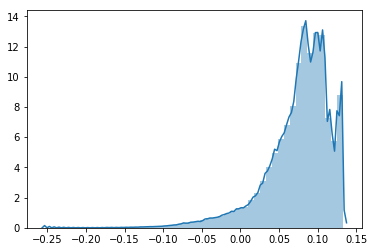

In [8]:
plot = sns.distplot(isolation_scores)

### Visualization

Processing data for PCA:

In [9]:
# one hot encoding and scaling data for PCA
categorical = data.columns[data.dtypes == 'category'].values
numeric = data.columns[data.dtypes != 'category'].values
data_for_dim_red = pd.get_dummies(data[categorical]).merge(data[numeric], left_index = True, right_index = True)
data_for_dim_red = StandardScaler().fit_transform(data_for_dim_red)

2D PCA:

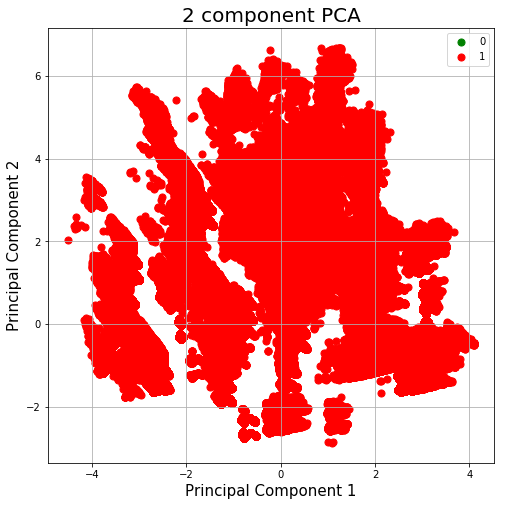

In [10]:
# PCA for 2 components
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(data_for_dim_red)
principalComponents = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
principalComponents['Predictions'] = predictions

# plotting the components
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = principalComponents['Predictions'] == target
    ax.scatter(principalComponents.loc[indicesToKeep, 'PC1']
               , principalComponents.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

3D PCA:

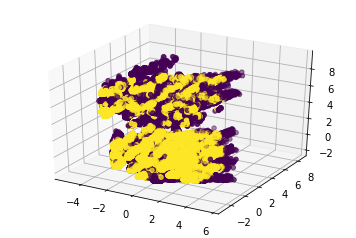

In [12]:
# PCA for 3 components
pca = PCA(n_components = 3)
principalComponents = pca.fit_transform(data_for_dim_red)
principalComponents = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3'])
principalComponents['Predictions'] = predictions

# plotting components
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(principalComponents['PC1'], principalComponents['PC2'], principalComponents['PC3'], 
             c = principalComponents['Predictions'], cmap = 'viridis');

tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
tsneComponents = tsne.fit_transform(data_for_dim_red)